In [1]:
train_root='/kaggle/input/sddataset/Datasetv1/train'
test_root='/kaggle/input/sddataset/Datasetv1/test'
valid_root='/kaggle/input/sddataset/Datasetv1/val'
IMAGE_HEIGHT = 224
IMAGE_WIDTH  = 224
IMAGE_CHANNEL = 3
BATCH_SIZE = 9
EPOCH_N = 99

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

eval_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)


train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

eval_generator = eval_datagen.flow_from_directory(valid_root,target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),batch_size=BATCH_SIZE,class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_root,target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),batch_size=BATCH_SIZE,class_mode='categorical', shuffle=False)
test_labels = test_generator.labels
print(test_labels)

train_steps = train_generator.n // BATCH_SIZE
val_steps = eval_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE
print('LEARNING_STEPS :--------> train_steps =', train_steps, ' |val_steps =', val_steps, ' |test_steps =', test_steps)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Found 10103 images belonging to 3 classes.
Found 2886 images belonging to 3 classes.
Found 1444 images belonging to 3 classes.
[0 0 0 ... 2 2 2]
LEARNING_STEPS :--------> train_steps = 1122  |val_steps = 320  |test_steps = 160


VGG16 Base_model

In [4]:
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


# Load the pre-trained NASNetMobile model without the top (fully connected) layers as base model
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add the NASNetMobile base
final_model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dense(512, activation='relu'),
        Dense(128, activation='relu'),
        Dense(3, activation='softmax')
    ])
 # Change the output units based on your problem

# Compile the model
final_model.compile(optimizer=Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])




19993432/19993432 [==============================] - 0s 0us/step


In [5]:

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau


checkpoint_callback = ModelCheckpoint(filepath='/kaggle/working/modelsdd(nas).{epoch:02d}-{val_loss:.2f}.h5', save_weights_only=False, monitor='val_acc', mode='max', save_best_only=False, period=1, verbose=1)


reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)

HISTORY_STATS = final_model.fit(train_generator, steps_per_epoch=train_steps, epochs=EPOCH_N, validation_data=eval_generator, validation_steps=val_steps, callbacks=[reduce_lr,checkpoint_callback])



Epoch 1/99
1122/1122 [==============================] - ETA: 0s - loss: 0.5610 - accuracy: 0.7706
Epoch 1: saving model to /kaggle/working/modelsdd(nas).01-0.56.h5
1122/1122 [==============================] - 338s 280ms/step - loss: 0.5610 - accuracy: 0.7706 - val_loss: 0.5600 - val_accuracy: 0.7743 - lr: 0.0010
Epoch 2/99
1122/1122 [==============================] - ETA: 0s - loss: 0.4438 - accuracy: 0.8262
Epoch 2: saving model to /kaggle/working/modelsdd(nas).02-0.48.h5
1122/1122 [==============================] - 264s 235ms/step - loss: 0.4438 - accuracy: 0.8262 - val_loss: 0.4820 - val_accuracy: 0.8149 - lr: 0.0010
Epoch 3/99
1122/1122 [==============================] - ETA: 0s - loss: 0.3994 - accuracy: 0.8410
Epoch 3: saving model to /kaggle/working/modelsdd(nas).03-0.47.h5
1122/1122 [==============================] - 250s 223ms/step - loss: 0.3994 - accuracy: 0.8410 - val_loss: 0.4739 - val_accuracy: 0.8097 - lr: 0.0010
Epoch 4/99
1122/1122 [==============================] - ET

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


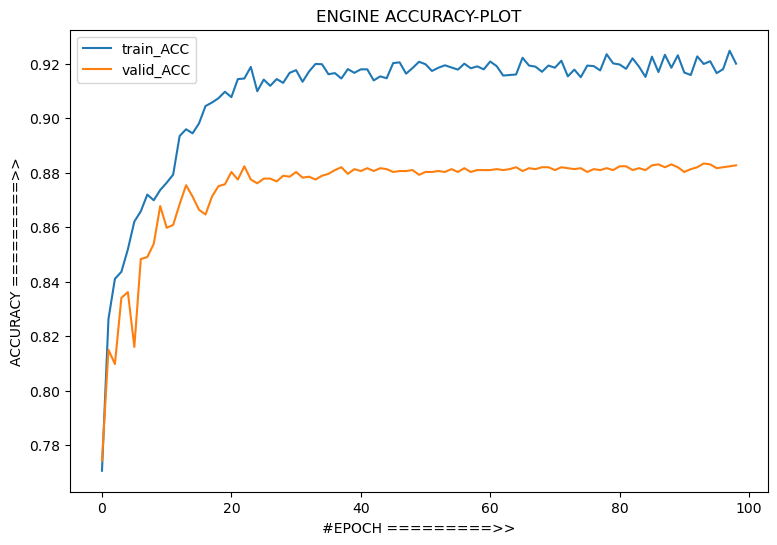

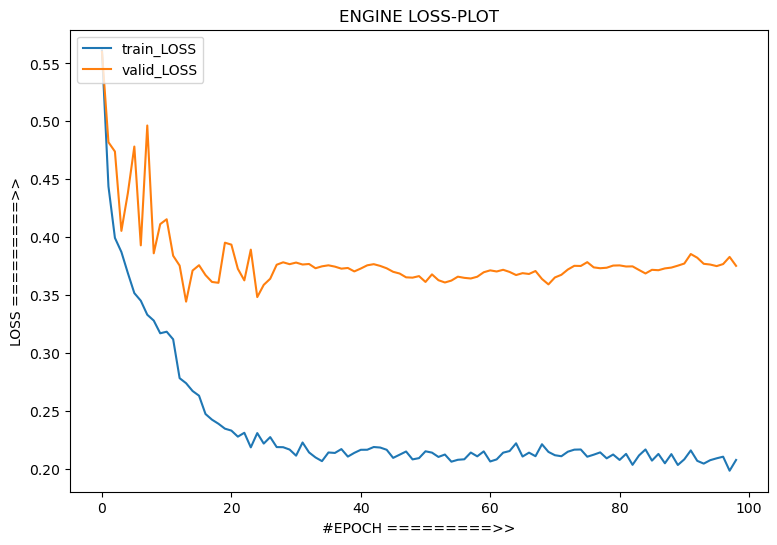

In [6]:
import matplotlib.pyplot as plt

print(HISTORY_STATS.history.keys())

fig=plt.figure(figsize=(9, 6))
plt.plot(HISTORY_STATS.history['accuracy'])
plt.plot(HISTORY_STATS.history['val_accuracy'])
plt.title('ENGINE ACCURACY-PLOT')
plt.ylabel('ACCURACY =========>>')
plt.xlabel('#EPOCH =========>>')
plt.legend(['train_ACC', 'valid_ACC'], loc='upper left')
plt.show()
fig.savefig('/kaggle/working/VGG16(sddaccuracy).png')


fig=plt.figure(figsize=(9, 6))
plt.plot(HISTORY_STATS.history['loss'])
plt.plot(HISTORY_STATS.history['val_loss'])
plt.title('ENGINE LOSS-PLOT')
plt.ylabel('LOSS =========>>')
plt.xlabel('#EPOCH =========>>')
plt.legend(['train_LOSS', 'valid_LOSS'], loc='upper left')
plt.show()
fig.savefig('/kaggle/working/VGG16(sddloss).png')

In [7]:
loss, acc = final_model.evaluate(train_generator, steps=train_steps, verbose=1)
print('TRAINING DATA LOSS & ACC.  ------------> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = final_model.evaluate(eval_generator, steps=val_steps, verbose=1)
print('VALDATION DATA LOSS & ACC. -----------> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = final_model.evaluate(test_generator, steps=test_steps, verbose=1)
print('TESTING DATA LOSS & ACC.   ------------> loss: %.3f, acc: %.3f' % (loss, acc))

1122/1122 [==============================] - 216s 192ms/step - loss: 0.2047 - accuracy: 0.9223
TRAINING DATA LOSS & ACC.  ------------> loss: 0.205, acc: 0.922
320/320 [==============================] - 28s 88ms/step - loss: 0.3754 - accuracy: 0.8826
VALDATION DATA LOSS & ACC. -----------> loss: 0.375, acc: 0.883
160/160 [==============================] - 24s 150ms/step - loss: 0.3306 - accuracy: 0.8833
TESTING DATA LOSS & ACC.   ------------> loss: 0.331, acc: 0.883


161/161 [==============================] - 20s 93ms/step
[[242   2  70]
 [  5 283  45]
 [ 27  20 750]]


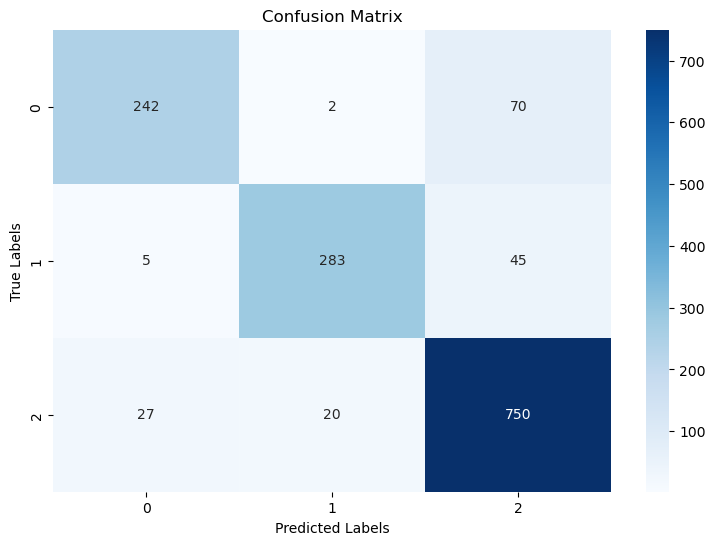

In [8]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import seaborn as sns
import numpy as np

# Prepare your test data
X_test = test_generator # Load your test input data
y_test = test_labels  # Load your test labels

# Generate predictions
y_pred = final_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Assuming the predictions are in one-hot encoded form

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

print(cm)
# Plot confusion matrix using seaborn
fig=plt.figure(figsize=(9, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
fig.savefig('/kaggle/working/VGG16(cm).png')